In [9]:
import torch 
import torchvision
import timm

model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)
model_2 =  torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained = False)
# model_3 = torchvision.models.vit_b_16() # more complicated

Using cache found in C:\Users\sarth/.cache\torch\hub\facebookresearch_dino_main


In [7]:
from torch import nn


dim = model.blocks[0].attn.qkv.in_features
adapter = nn.Sequential()
for t_layer_i in range(len(model.blocks)//2):
    adapter.add_module("layer_" + str(t_layer_i), nn.Linear(dim, dim))
    adapter.add_module("relu_" + str(t_layer_i), nn.ReLU())
adapter.add_module("fc", nn.Linear(dim, 30))

In [31]:
for p in model.parameters():
    p.requires_grad = False
for p in range(len(model.blocks)):
    for param in model.blocks[p].attn.qkv.parameters():
        param.requires_grad = True

In [3]:
trial = torch.nn.Sequential(
    torch.nn.Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16)), 
    torch.nn.Flatten(-2,-1)
)
norm_layer = torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True)
norm_layer(trial(torch.randn(1,3,224,224)).permute(0,2,1)).shape

torch.Size([1, 196, 768])

### DINO Attention (Visualize_attention.py)

In [10]:
x = model_2.get_last_selfattention(torch.randn(1,3,224,224))
# print(x.shape)
# x = x[0,:,0,1:]
# x.shape

In [11]:
x.shape

torch.Size([1, 6, 197, 197])

### Getting attention maps patchwise from the model

In [36]:
feats = {}
def hook(module, input, output):
    input = input[0]
    B, N, C = input.shape
    qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    print(module.qkv(input).shape)
    print(qkv.shape)
    print(output.shape)
    feats['q'] = qkv[0]
    feats['k'] = qkv[1]
    feats['v'] = qkv[2]

id = model.blocks[-1].attn.register_forward_hook(hook)
# id = model.patch_embed.register_forward_hook(hook)
_ = model(torch.randn(1,3,224,224))
id.remove()

torch.Size([1, 197, 2304])
torch.Size([3, 1, 12, 197, 64])
torch.Size([1, 197, 768])


In [7]:
for k,v in feats.items():
    print(v.shape)
q = feats['q']
k = feats['k']

scale = q.shape[-1] ** -0.5
attn = (q@k.transpose(-2, -1))*scale
attn = attn.softmax(dim=-1)
attn.shape

torch.Size([1, 12, 197, 64])
torch.Size([1, 12, 197, 64])
torch.Size([1, 12, 197, 64])


torch.Size([1, 12, 197, 197])

In [13]:
(attn@v).permute(0,2,1,3).flatten(2).shape

torch.Size([1, 197, 768])

### Can we use Jensen Shannon Divergence
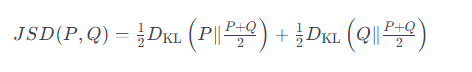
https://proceedings.neurips.cc/paper/2021/file/fe2d010308a6b3799a3d9c728ee74244-Paper.pdf


https://openaccess.thecvf.com/content_CVPR_2019/papers/Guo_Visual_Attention_Consistency_Under_Image_Transforms_for_Multi-Label_Image_Classification_CVPR_2019_paper.pdf

# Idea

Suppose we have an Image $x$ and we transform it using a function g to get and augmented image $g(x)$. Now after passing the inputs through the model we get the attention maps $A_1$ and $A_2$ 

Loss Function Concept: $g(A_1)$ and $A_2$ should be similar and hence compared 

For comparing the labels: weighted sigmoid cross entropy loss (used in the other paper)

KL Divergence or JS divergence -  we can global pool the features and apply divergence on them (Ask sir once)

Transformation: Translation, rotation, flipping, scalling

[1, 196, 768] will be the output from the attention layer where the second dimension corresponds to the patches. 

Since the divergence is computed on 2 distributions, 2 ideas:
- We use the Q,V between to get a 4D tensor and then compute the divergence between 2 images (assumption: the distribution of attention maps across different pixels should be the same)
- We get the output of the attention layer and then we perform some operations on it after that we compare this distribution over multiple images

In [14]:
import torch
from torch import nn

loss = nn.KLDivLoss()
x1 = torch.randn(1,1, 196*12, 196).softmax(dim = -1)
x2 = torch.randn(1,1, 196*12, 196).softmax(dim = -1)

print(f'KL Divergence: {loss(x1,x2)}')
print(f'JS Divergence: {0.5*loss(x1,(x1+x2)/2)+0.5*loss(x2,(x1+x2)/2)}')

KL Divergence: -0.024447957053780556
JS Divergence: -0.02549160271883011


In [33]:
from torch import nn

x = torch.randn([1, 8, 197, 197])
x = x[:,:,1:,1:].reshape(1,8,14,14,14,14)
y = []
for i in range(8):
    print(nn.AvgPool2d(14,14)(x[:,i].squeeze(1).reshape(1,196,14,14)).shape)
    y.append(nn.AvgPool2d(14,14)(x[:,i].squeeze(1).reshape(1,196,14,14)).squeeze(-1).squeeze(-1))

torch.cat(y, dim = 0).shape

torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])


torch.Size([8, 196])

In [59]:
x = torch.randn(1,196,768)
x = x.transpose(-2,-1)
print(x.shape)
x = x.reshape(x.shape[0], 768,14,14)
print(x.shape)
nn.AvgPool2d(8,8)(x).shape

torch.Size([1, 768, 196])
torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 1, 1])

# Understanding Attention in ViT

In [8]:
inp = torch.randn(1,197,768)
num_heads = 8
head_dim = 768//num_heads
scale = head_dim ** -0.5
qkv = torch.nn.Linear(768, 768*3)
proj = torch.nn.Linear(768,768)

In [9]:
qkv(inp).shape

torch.Size([1, 197, 2304])

In [10]:
b,n,c = inp.shape
temp = qkv(inp).reshape(b,n,3,num_heads, head_dim).permute(2, 0, 3, 1, 4)
q,k,v = temp.unbind(0)
q.shape

torch.Size([1, 8, 197, 96])

In [12]:
attn = q@k.transpose(-2,-1)
attn = attn.softmax(dim = -1)
attn.shape, v.shape

(torch.Size([1, 8, 197, 197]), torch.Size([1, 8, 197, 96]))

In [13]:
(attn@v).transpose(1,2).reshape(b,n,c).shape

torch.Size([1, 197, 768])

In [59]:
b,n,c

(1, 197, 768)

# Understanding Attention in stable diffusion

### Linear Attention 
https://arxiv.org/ftp/arxiv/papers/2007/2007.14902.pdf

In [169]:
from torch import nn, einsum
from einops import rearrange, repeat
dim = in_channels = 64
heads=4 
dim_head=32
hidden_dim = dim_head * heads # 
to_qkv = torch.nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
to_out = torch.nn.Conv2d(hidden_dim, dim, 1)

inp = torch.randn(1,64,32,32)

In [185]:
b,c,h,w = inp.shape
qkv = to_qkv(inp)
q,k,v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = heads, qkv=3)
k = k.softmax(dim=-1)  
qkv.shape, q.shape, k.shape, v.shape

(torch.Size([1, 384, 32, 32]),
 torch.Size([1, 4, 32, 1024]),
 torch.Size([1, 4, 32, 1024]),
 torch.Size([1, 4, 32, 1024]))

In [186]:
context = torch.einsum('bhdn,bhen->bhde', k, v)
context.shape

torch.Size([1, 4, 32, 32])

In [187]:
((k@v.transpose(-2,-1)) == context).all()

tensor(True)

In [188]:
out = torch.einsum('bhde,bhdn->bhen', context, q)
out.shape

torch.Size([1, 4, 32, 1024])

In [196]:
((context.transpose(-1,-2)@q) == out).all()

tensor(True)

In [197]:
out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=heads, h=h, w=w)
out.shape

torch.Size([1, 128, 32, 32])

In [201]:
((context.transpose(-1,-2)@q).reshape(b,128, h, w) == out).all()

tensor(True)

### Spatial self attention

In [135]:
in_channels = 64
inp = torch.randn(1,64,32,32)

q_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
k_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
v_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
proj_out = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)

In [136]:
q = q_linear(inp);k = k_linear(inp);v = v_linear(inp)
q.shape, k.shape, v.shape

(torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]))

In [137]:
b,c,h,w = q.shape

q1 = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k1 = rearrange(k, 'b c h w -> b (h w) c')
method_1 = q1@k1.transpose(-1,-2)
q1.shape, k1.shape

(torch.Size([1, 1024, 64]), torch.Size([1, 1024, 64]))

In [138]:
q2 = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k2 = rearrange(k, 'b c h w -> b c (h w)')
method_2 = torch.einsum('bij,bjk->bik', q2, k2)
q2.shape, k2.shape

(torch.Size([1, 1024, 64]), torch.Size([1, 64, 1024]))

In [139]:
(method_1 == method_2).all()

tensor(True)

In [140]:
q = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k = rearrange(k, 'b c h w -> b (h w) c')
v = rearrange(v, 'b c h w -> b (h w) c')
scale = int(c) ** -0.5 # scale is taken of the -1 dim
attn = q1@k1.transpose(-1,-2) * (scale)
attn = attn.softmax(dim = -1)

In [142]:
attn.shape, v.shape

(torch.Size([1, 1024, 1024]), torch.Size([1, 1024, 64]))

In [154]:
(attn@v) == torch.einsum('bij,bjk -> bki', v.transpose(-2,-1), attn.transpose(-2,-1))

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]]])

In [155]:
(attn@v) == torch.einsum('bij,bjk -> bik', attn, v)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [158]:
x = attn@v
x.shape

torch.Size([1, 1024, 64])

In [160]:
x = rearrange(x, 'b (h w) c -> b c h w', h = h)
x.shape

torch.Size([1, 64, 32, 32])

In [161]:
proj_out(x).shape

torch.Size([1, 64, 32, 32])

In [210]:
rearrange(attn, 'b (h1 w1) (h2 w2) -> b h1 w1 h2 w2', h1=32, h2 = 32).shape

torch.Size([1, 32, 32, 32, 32])

In [211]:
proj_out(x).shape

torch.Size([1, 64, 32, 32])

### Checking of storing transforms

In [3]:
import albumentations as A
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
transform = A.Compose([
    A.HorizontalFlip(p=1),
])
transform2 = transforms.RandomHorizontalFlip(p=1)

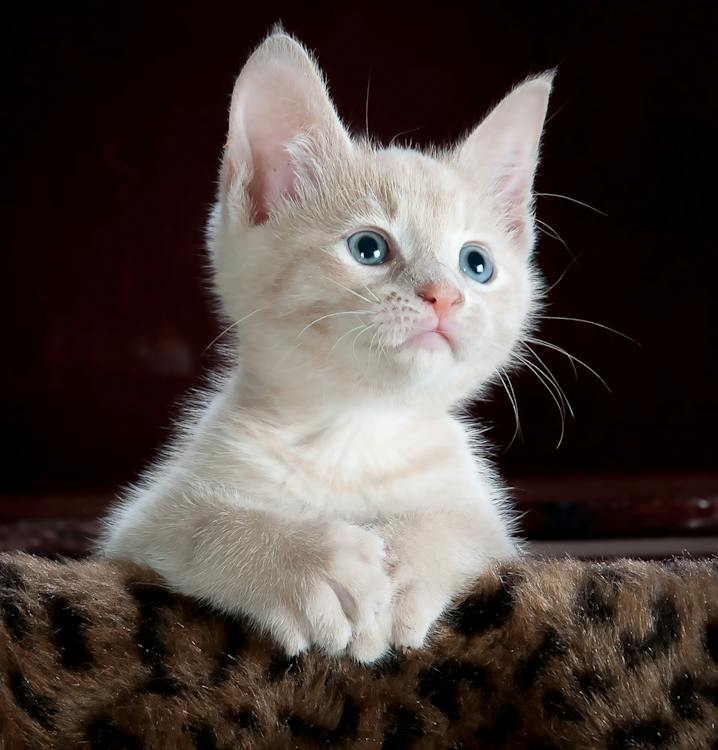

In [4]:
Image.open('cat.jpg')

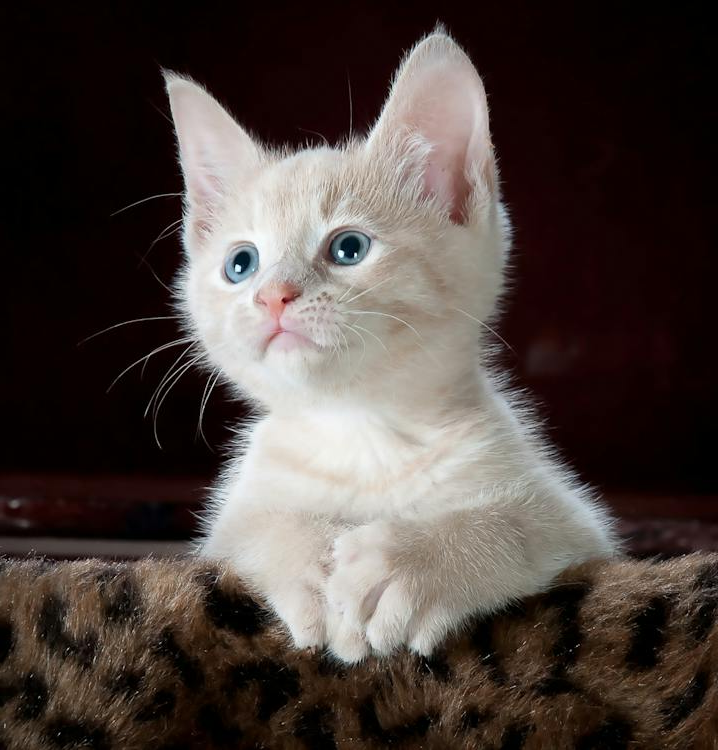

In [5]:
# Image.fromarray(transform(image = np.array(Image.open('cat.jpg')))['image'])
transform2(Image.open('cat.jpg'))

In [6]:
def flip(x):
    x1 = torch.zeros_like(x)
    for k in range(x.shape[-1]):
        x1[:,:,:,:,:,x.shape[-1] - 1 - k] = x[:,:,:,:,:,k]

    return x1

In [8]:
inp = torch.randn(8,12,14,14,14,14)

(transform2(inp) == flip(inp)).all()

tensor(True)

In [22]:
def horizontal_flip(x):
    x1 = torch.zeros_like(x)
    
    # for i in range(x.shape[1]):
    #     for j in range(x.shape[2]):
    #         x1[:,i,x.shape[2]-1-j,:,:] = x[:,i,j,:,:]
    #  for i in range(x.shape[3]):
    for j in range(x.shape[-1]):
        x1[:,:,:,:,x.shape[-1]-1-j] = x[:,:,:,:,j]

    return x1

In [14]:
from model import Model
import torch
model = Model()
items = model(torch.randn(8,3,224,224),torch.randn(8,3,224,224)) #assuming transformation is horizontal
for i in items:
    print(i.shape)

self_attn_1, output_1, self_attn_2, output_2 = items

torch.Size([8, 6, 196, 196])
torch.Size([8, 6, 14, 14, 14, 14])
torch.Size([8, 30])
torch.Size([8, 6, 14, 14, 14, 14])
torch.Size([8, 30])


In [15]:
model.parameters()
optim = torch.optim.Adam(model.parameters())
optim.zero_grad()
optim.step

<bound method Adam.step of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)>

In [16]:
from utils_own import horizontal_flip, vertical_flip, horizontal_flip_target, vertical_flip_target
from torchvision import transforms
# transform = transforms.RandomHorizontalFlip(p=1)
# transform2 = transforms.RandomVerticalFlip(p=1)

# (horizontal_flip(self_attn_1) == transform(self_attn_1)).all(), (vertical_flip(self_attn_1) == transform2(self_attn_1)).all()

self_attn_2 = horizontal_flip_target(horizontal_flip(self_attn_2))

In [7]:
loss = torch.nn.MSELoss()
loss(self_attn_1, self_attn_2)*10**6

tensor(3.8061, grad_fn=<MulBackward0>)

In [ ]:
loss2 = torch.nn.CrossEntropyLoss()
loss2(output_1.softmax(dim=-1), torch.randn(32).to(torch.float32))

In [41]:
from data import train_dataset

image_1, image_2, label, _ = train_dataset().__getitem__(0)

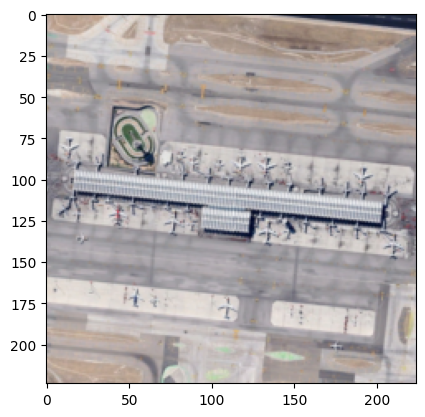

In [45]:
import matplotlib.pyplot as plt

plt.imshow(image_1.permute(1,2,0))

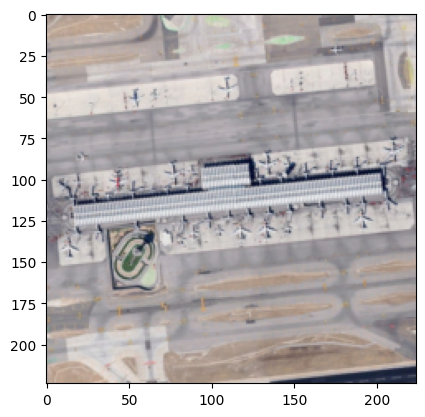

In [46]:
plt.imshow(image_2.permute(1,2,0))

In [20]:
import pandas as pd 
import os
from os.path import join

frames = []

source = 'Datasets/UCMerced_LandUse/'

for folder in os.listdir(source):
    for image in os.listdir(join(source, folder)):
        frames.append(pd.DataFrame({
            'image':join(source, folder,image),
            'label_name':folder
        }, index = [0]))

df = pd.concat(frames)
labels = {j:i for i,j in enumerate(df.label_name.unique())}

df['label'] = df['label_name'].apply(lambda x:labels[x])
df.reset_index(drop = True).to_csv('Datasets/UCMerced_LandUse.csv', index = False)

In [3]:
import pandas as pd
df = pd.read_csv('Datasets/AID.csv')
df

,Unnamed: 0,image,label_name,label
0,0,Datasets\AID\Airport\airport_1.jpg,Airport,0
1,1,Datasets\AID\Airport\airport_10.jpg,Airport,0
2,2,Datasets\AID\Airport\airport_100.jpg,Airport,0
3,3,Datasets\AID\Airport\airport_101.jpg,Airport,0
4,4,Datasets\AID\Airport\airport_102.jpg,Airport,0
...,...,...,...,...
9995,9995,Datasets\AID\Viaduct\viaduct_95.jpg,Viaduct,29
9996,9996,Datasets\AID\Viaduct\viaduct_96.jpg,Viaduct,29
9997,9997,Datasets\AID\Viaduct\viaduct_97.jpg,Viaduct,29
9998,9998,Datasets\AID\Viaduct\viaduct_98.jpg,Viaduct,29


In [4]:
test = df.sample(frac = 0.2, replace = False).reset_index(drop = True)
train = df[~df['image'].isin(test['image'].values)].reset_index(drop = True)
train

,Unnamed: 0,image,label_name,label
0,0,Datasets\AID\Airport\airport_1.jpg,Airport,0
1,1,Datasets\AID\Airport\airport_10.jpg,Airport,0
2,2,Datasets\AID\Airport\airport_100.jpg,Airport,0
3,3,Datasets\AID\Airport\airport_101.jpg,Airport,0
4,4,Datasets\AID\Airport\airport_102.jpg,Airport,0
...,...,...,...,...
7995,9995,Datasets\AID\Viaduct\viaduct_95.jpg,Viaduct,29
7996,9996,Datasets\AID\Viaduct\viaduct_96.jpg,Viaduct,29
7997,9997,Datasets\AID\Viaduct\viaduct_97.jpg,Viaduct,29
7998,9998,Datasets\AID\Viaduct\viaduct_98.jpg,Viaduct,29


In [5]:
# train.to_csv('Datasets/UCMerced_LandUse_train.csv', index = False)
test.to_csv('Datasets/AID_test.csv', index = False)


In [3]:
from model import LORAModel
import torch
model = LORAModel()

self_attn_1, o1, self_attn_2, o2 = model(torch.randn(2,3,224,224),torch.randn(2,3,224,224))

In [4]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"trainable parameters: {num_params/2**20:.3f}M")
num_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {num_params/2**20:.3f}M")

trainable parameters: 0.116M
total parameters: 20.778M


In [44]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"trainable parameters: {num_params/2**20:.3f}M")
num_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {num_params/2**20:.3f}M")

trainable parameters: 0.081M
total parameters: 20.743M


In [2]:
from lora import LoRA_ViT_timm_mod
import timm
import torch
model = LoRA_ViT_timm_mod(timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True), r=4)
model(torch.randn(1,3,224,224));

In [13]:
qkv = torch.randn(1,197,1152)
dim = 384

In [26]:
import pandas as pd 

df = pd.read_csv('Datasets/UCMerced_LandUse_train.csv')

frames = []

for i in range(len(df)):
    row = df.iloc[i]
    df_pos = df[df['label']==row['label']]
    df_neg = df[df['label']!=row['label']]
    pos = df_pos.sample(n = 1).reset_index(drop=True).iloc[0]
    neg = df_neg.sample(n = 1).reset_index(drop=True).iloc[0]
    frames.append(pd.DataFrame({
        'image':row['image'],
        'label':row['label'],
        'label_name':row['label_name'],
        'image_pos':pos['image'],
        'label_pos':pos['label'],
        'label_name_pos':pos['label_name'],
        'image_neg':neg['image'],
        'label_neg':neg['label'],
        'label_name_neg':neg['label_name'],
    },index = [0]))

In [27]:
pd.concat(frames).reset_index(drop = True).to_csv('Datasets/UCMerced_LandUse_triplet_train.csv', index = False)

In [37]:
import pandas as pd
df1 = pd.read_csv('PatternNet_train.csv')
df2 = pd.read_csv('PatternNet_triplet.csv')

pd.merge(df1, df2, how='outer',on='image').rename(columns={'label_name_x':'label_name', 'label_x':'label'}).drop(columns=['label_y', 'label_name_y'])

,image,label_name,label,image_pos,label_pos,label_name_pos,image_neg,label_neg,label_name_neg
0,AID\Airport\airport_1.jpg,Airport,0,AID\Airport\airport_277.jpg,0,Airport,AID\Square\square_220.jpg,26,Square
1,AID\Airport\airport_101.jpg,Airport,0,AID\Airport\airport_347.jpg,0,Airport,AID\Commercial\commercial_201.jpg,7,Commercial
2,AID\Airport\airport_102.jpg,Airport,0,AID\Airport\airport_32.jpg,0,Airport,AID\Park\park_173.jpg,16,Park
3,AID\Airport\airport_103.jpg,Airport,0,AID\Airport\airport_351.jpg,0,Airport,AID\Beach\beach_17.jpg,3,Beach
4,AID\Airport\airport_105.jpg,Airport,0,AID\Airport\airport_194.jpg,0,Airport,AID\Square\square_16.jpg,26,Square
...,...,...,...,...,...,...,...,...,...
7995,AID\Viaduct\viaduct_94.jpg,Viaduct,29,AID\Viaduct\viaduct_262.jpg,29,Viaduct,AID\Beach\beach_397.jpg,3,Beach
7996,AID\Viaduct\viaduct_95.jpg,Viaduct,29,AID\Viaduct\viaduct_7.jpg,29,Viaduct,AID\StorageTanks\storagetanks_268.jpg,28,StorageTanks
7997,AID\Viaduct\viaduct_97.jpg,Viaduct,29,AID\Viaduct\viaduct_383.jpg,29,Viaduct,AID\Resort\resort_40.jpg,22,Resort
7998,AID\Viaduct\viaduct_98.jpg,Viaduct,29,AID\Viaduct\viaduct_324.jpg,29,Viaduct,AID\Farmland\farmland_89.jpg,10,Farmland


In [38]:
from torch import nn
import torch

loss_fn = nn.TripletMarginLoss()

loss_fn(torch.randn(32,384),torch.randn(32,384),torch.randn(32,384))

tensor(1.1240)

In [50]:
from torch import nn
import torch


nn.TripletMarginLoss()(torch.randn(32),torch.randn(32),torch.randn(32)).requires_grad


False

In [52]:
nn.MSELoss()(torch.randn(32),torch.randn(32)).requires_grad

False

In [55]:
torch.tensor(0., requires_grad = True)

tensor(0., requires_grad=True)

### GRADCAM implementation testing

In [7]:
from gradcam import GradCAM
import torch
import timm
from PIL import Image
from torchvision import transforms 

img = Image.open('AID/Airport/airport_1.jpg')
img = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])(img).unsqueeze(0).to('cuda')
model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)

cam = GradCAM(model, target_layer=model.blocks[-1].norm1)


In [8]:
cam(img, img.size()[2:])


c:\Users\sarth\miniconda3\envs\seg\lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

Model loaded successfully


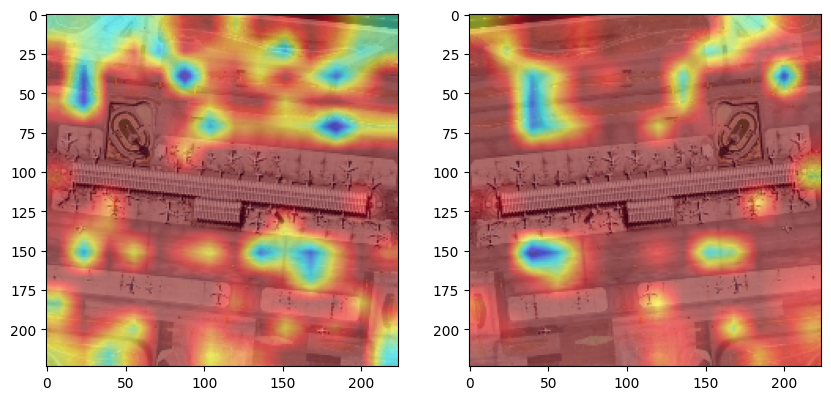

In [7]:
import argparse
import cv2
import numpy as np
import torch
import timm
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from model import LORAModel
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """

    args = {
        'use_cuda':True,
        'image_path':'Datasets/AID/Airport/airport_1.jpg',
        'aug_smooth':False,
        'eigen_smooth':False,
        'method':'gradcam'
    }
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    if args["method"] not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    # model = torch.hub.load('facebookresearch/deit:main',
    #                        'deit_tiny_patch16_224', pretrained=True)
    # model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)
    model = LORAModel()
    model.load_model(r'Experiments_all\Experiments_AID\lora_without_attn_loss', latest=False)
    model.eval()

    if args["use_cuda"]:
        model = model.cuda()

    target_layers = [model.model.blocks[-1].norm1]

    if args["method"] not in methods:
        raise Exception(f"Method {args['method']} not implemented")

    if args["method"] == "ablationcam":
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   use_cuda=args["use_cuda"],
                                   reshape_transform=reshape_transform,
                                   ablation_layer=AblationLayerVit())
    else:
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   reshape_transform=reshape_transform)

    rgb_img = cv2.imread(args["image_path"], 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args["eigen_smooth"],
                        aug_smooth=args["aug_smooth"])

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    # cv2.imwrite(f'{args["method"]}_cam.jpg', cam_image)

    rgb_img = cv2.imread('test_image.png', 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args["eigen_smooth"],
                        aug_smooth=args["aug_smooth"])

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image2 = show_cam_on_image(rgb_img, grayscale_cam)

from matplotlib import pyplot as plt 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cam_image)
plt.subplot(1,2,2)
plt.imshow(cam_image2)

Model loaded successfully


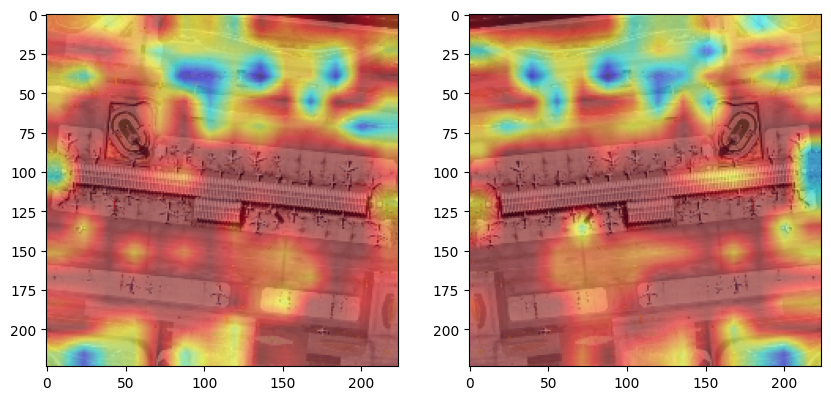

In [8]:
import argparse
import cv2
import numpy as np
import torch
import timm
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from model import LORAModel
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """

    args = {
        'use_cuda':True,
        'image_path':'Datasets/AID/Airport/airport_1.jpg',
        'aug_smooth':False,
        'eigen_smooth':False,
        'method':'gradcam'
    }
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    if args["method"] not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    # model = torch.hub.load('facebookresearch/deit:main',
    #                        'deit_tiny_patch16_224', pretrained=True)
    # model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)
    model = LORAModel()
    model.load_model(r'Experiments_all\Experiments_AID\lora_with_attn_loss_lesser_weight_2', latest=False)
    model.eval()

    if args["use_cuda"]:
        model = model.cuda()

    target_layers = [model.model.blocks[-1].norm1]

    if args["method"] not in methods:
        raise Exception(f"Method {args['method']} not implemented")

    if args["method"] == "ablationcam":
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   use_cuda=args["use_cuda"],
                                   reshape_transform=reshape_transform,
                                   ablation_layer=AblationLayerVit())
    else:
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   reshape_transform=reshape_transform)

    rgb_img = cv2.imread(args["image_path"], 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args["eigen_smooth"],
                        aug_smooth=args["aug_smooth"])

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    # cv2.imwrite(f'{args["method"]}_cam.jpg', cam_image)

    rgb_img = cv2.imread('test_image.png', 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args["eigen_smooth"],
                        aug_smooth=args["aug_smooth"])

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image2 = show_cam_on_image(rgb_img, grayscale_cam)

from matplotlib import pyplot as plt 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cam_image)
plt.subplot(1,2,2)
plt.imshow(cam_image2)

### Visualizing attention


c:\Users\sarth\miniconda3\envs\seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sarth\miniconda3\envs\seg\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Model loaded successfully


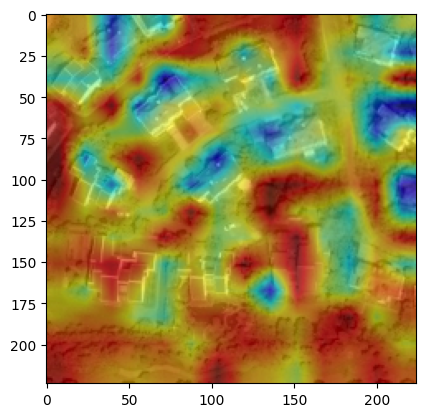

In [1]:
import argparse
import cv2
import numpy as np
import torch
import timm
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from model import LORAModel
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


if __name__ == '__main__':
    """ python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """

    args = {
        'use_cuda':True,
        'image_path':r'Datasets\AID\MediumResidential\mediumresidential_3.jpg',
        'aug_smooth':False,
        'eigen_smooth':False,
        'method':'gradcam'
    }
    methods = \
        {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad}

    if args["method"] not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    # model = torch.hub.load('facebookresearch/deit:main',
    #                        'deit_tiny_patch16_224', pretrained=True)
    # model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)
    model = LORAModel()
    model.load_model(r'Experiments_all\Experiments_AID\lora_with_attn_loss_lesser_weight_2', latest=False)
    model.eval()

    if args["use_cuda"]:
        model = model.cuda()

    target_layers = [model.model.blocks[-1].norm1]

    if args["method"] not in methods:
        raise Exception(f"Method {args['method']} not implemented")

    if args["method"] == "ablationcam":
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   use_cuda=args["use_cuda"],
                                   reshape_transform=reshape_transform,
                                   ablation_layer=AblationLayerVit())
    else:
        cam = methods[args["method"]](model=model,
                                   target_layers=target_layers,
                                   reshape_transform=reshape_transform)

    rgb_img = cv2.imread(args["image_path"], 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=args["eigen_smooth"],
                        aug_smooth=args["aug_smooth"])

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    # cv2.imwrite(f'{args["method"]}_cam.jpg', cam_image)


from matplotlib import pyplot as plt 

plt.imshow(cam_image)

Model loaded successfully
Model loaded successfully


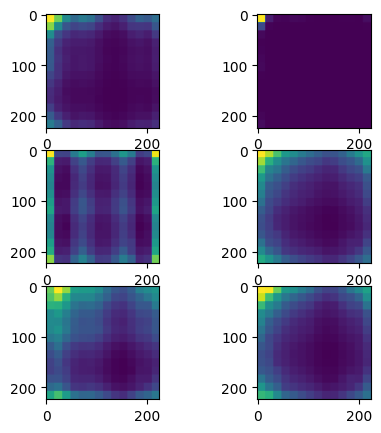

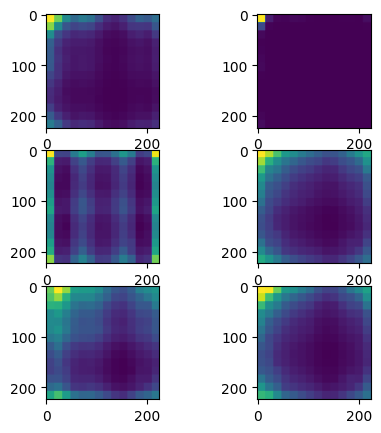

In [15]:
import torch 
from torch import nn
import timm
import numpy as np
from matplotlib import pyplot as plt 
from model import LORAModel
from PIL import Image
from torchvision import transforms
device = 'cuda'
transform = transforms.Compose(
    [transforms.Resize(224), 
    transforms.ToTensor()]
)

def get_attn_maps(image_path):
    model = LORAModel()
    model.load_model(r'Experiments_all\Experiments_AID\lora_with_attn_loss_lesser_weight_2', latest=False)

    feats = {}
    def hook(module, input, output):
        input = input[0]
        B, N, C = input.shape
        qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
        feats['q'] = q = qkv[0]
        feats['k'] = k = qkv[1]
        feats['v'] = qkv[2]
        scale = q.shape[-1] ** -0.5
        attn = (q@k.transpose(-2, -1))*scale
        attn = attn.softmax(dim=-1)
        feats['attn'] = attn

    img = transform(Image.open(image_path)).unsqueeze(0)

    id = model.model.blocks[0].attn.register_forward_hook(hook)
    _ = model(img)
    id.remove()

    nh = feats['attn'].shape[1]
    attentions = feats['attn'][0, :, 1, 1:].reshape(nh, -1).reshape(nh,14,14)

    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].detach().cpu().numpy()

    plt.figure(figsize=(5,5))
    for i in range(nh):
        plt.subplot(3,2,i+1)
        plt.imshow(attentions[i])

    return attentions, feats['attn']


attn_1, attn_11 = get_attn_maps(r'Datasets\AID\MediumResidential\mediumresidential_3.jpg')
attn_2, attn_21 = get_attn_maps(r'Datasets\AID\BaseballField\baseballfield_2.jpg')

In [8]:
import os
from os.path import join
import pandas as pd 

for file in os.listdir('Datasets'):
    if file[-4:] == '.csv':
        df = pd.read_csv(join('Datasets',file))
        df['image'] = df['image'].apply(lambda x:join('Datasets', x))
        
        # df.to_csv(join('Datasets',file), index = False)



In [25]:
import timm
import torch
from torch import nn
import math 
from functools import reduce
from operator import mul

model = timm.create_model('vit_small_patch16_224',num_classes = 10, pretrained=True)

def hook(module, input, output):
    print(module)
    print(len(input))
    print(input[0].shape)
    print(output.shape)

id = model.norm_pre.register_forward_hook(hook)
_ = model(torch.rand(1,3,224,224))
id.remove()

Identity()
1
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])


In [26]:
class VPT(nn.Module):
    def __init__(self, num_tokens):
        super().__init__()
        # val = math.sqrt(6. / float(3 * reduce(mul, 16, 1) + 384))  # noqa
        self.num_tokens = num_tokens
        self.prompt_embeddings = nn.Parameter(torch.zeros(
            1, num_tokens, 384))
        # xavier_uniform initialization
        # nn.init.uniform_(self.prompt_embeddings.data, -val, val)
    
    def forward(self, x):
        B = x.shape[0]
        out = torch.cat((
                x[:, :1, :],
                self.prompt_embeddings.expand(B, -1, -1),
                x[:, 1:, :]
            ), dim=1)
        return out   

In [27]:
model.norm_pre = VPT(num_tokens=2)

In [28]:
feats = []
# Using multiple layers

def hook(module, input, output):
    input = input[0]
    B, N, C = input.shape
    qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    q = qkv[0][:,:,3:,:]
    print(q.shape)
    k = qkv[1]
    v = qkv[2]
    scale = q.shape[-1] ** -0.5
    attn = (q@k.transpose(-2, -1))*scale
    attn = attn.softmax(dim=-1)
    feats.append(attn)

id = model.blocks[-1].attn.register_forward_hook(hook)

_ = model(torch.rand(1,3,224,224))
id.remove()

torch.Size([1, 6, 196, 64])


In [29]:
feats[0].shape

torch.Size([1, 6, 196, 199])